# Ejercicio 1

A partir del dataset de registros de publicaciones en Facebook sobre Tailandia. Clasificar los diferentes registros utilizando el algoritmo K-means (preparar/limpiar los datos).

# Ejercicio 2

Clasificar los diferentes registros utilizando el algoritmo de clustering jerárquico.

# Ejercicio 3

Calcular el rendimiento del clustering mediante un parámetro como por ejemplo Silhouette.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from matplotlib.ticker import MultipleLocator  # Para especificar posición de los "ticks".
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch   # Este y el siguiente, para hierarchical clustering:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist   # Para medir "cophenetic distance".
from sklearn.cluster import SpectralClustering

### Carga e inspección/limpieza inicial de los datos

In [2]:
facebook_tailandia = pd.read_csv(r'Publicacions Facebook Thailandia.csv')

In [3]:
facebook_tailandia

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045,1050855161656896_1061863470556065,photo,9/24/2016 2:58,89,0,0,89,0,0,0,0,0,NaN,NaN,NaN,NaN
7046,1050855161656896_1061334757275603,photo,9/23/2016 11:19,16,0,0,14,1,0,1,0,0,NaN,NaN,NaN,NaN
7047,1050855161656896_1060126464063099,photo,9/21/2016 23:03,2,0,0,1,1,0,0,0,0,NaN,NaN,NaN,NaN
7048,1050855161656896_1058663487542730,photo,9/20/2016 0:43,351,12,22,349,2,0,0,0,0,NaN,NaN,NaN,NaN


Tenemos una serie de campos numéricos, uno con fecha y hora, otro con una variable categórica, y otro con una "etiqueta" que realmente no aporta información. Esa la borramos ya, "status_id".

In [4]:
facebook_tailandia = facebook_tailandia.drop(["status_id"], axis=1)

Veamos el número de celdas de cada columna que contienen valores nulos ("NaNs").

In [5]:
facebook_tailandia.isnull().sum()

status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             7050
Column2             7050
Column3             7050
Column4             7050
dtype: int64

Hemos podido constatar que las últimas cuatro columnas no contienen datos (parece que todo son valores nulos, "NaN"). Por lo tanto, eliminamos también esas columnas.

In [6]:
facebook_tailandia = facebook_tailandia.drop(['Column1', 'Column2', 'Column3', 'Column4'], axis = 1)

Comprobamos ahora también si hay duplicados. De hecho, vemos que sí, y hay 54:

In [7]:
facebook_tailandia.duplicated().sum()

54

In [8]:
# Por si quisiéramos inspeccionarlos:
# duplicates = facebook_tailandia[facebook_tailandia.duplicated()]  # Seleccionamos las que son duplicadas...

Visto que hay duplicados, borramos esos registros, quedándonos solamente con su primera aparición:

In [9]:
facebook_tailandia = facebook_tailandia.drop_duplicates(keep='first')

In [10]:
facebook_tailandia

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0
1,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0
2,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0
3,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0
4,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7045,photo,9/24/2016 2:58,89,0,0,89,0,0,0,0,0
7046,photo,9/23/2016 11:19,16,0,0,14,1,0,1,0,0
7047,photo,9/21/2016 23:03,2,0,0,1,1,0,0,0,0
7048,photo,9/20/2016 0:43,351,12,22,349,2,0,0,0,0


In [11]:
duplicates = facebook_tailandia[facebook_tailandia.duplicated()]
duplicates  # Ya no quedan duplicados.

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys


Veamos ahora el número de celdas por columna que tienen valor igual a cero:

In [12]:
(facebook_tailandia == 0).sum()

status_type            0
status_published       0
num_reactions        118
num_comments        2116
num_shares          3905
num_likes            123
num_loves           4225
num_wows            5294
num_hahas           5879
num_sads            6398
num_angrys          6576
dtype: int64

In [13]:
# Número de celdas con registros no-nulos de cada columna:
6996-(facebook_tailandia == 0).sum()

status_type         6996
status_published    6996
num_reactions       6878
num_comments        4880
num_shares          3091
num_likes           6873
num_loves           2771
num_wows            1702
num_hahas           1117
num_sads             598
num_angrys           420
dtype: int64

En intentos iniciales, he constatado que las últimas columnas parecen distorsionar el trabajo con el resto de variables (dado que contienen un gran número de ceros).

Podríamos plantearnos fusionar las emociones "muy positivas" (num_loves, num_wows), y por otra parte fusionar las negativas (num_sads, num_angrys), con el beneficio añadido de reducir la dimensionalidad.

In [14]:
facebook_tailandia.head()

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0
1,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0
2,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0
3,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0
4,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0


In [15]:
# Fusionamos "num_wows" y "num_loves"
# Renombramos la columna "num_loves" a "num_loves_wows":
facebook_tailandia.rename(columns={'num_loves': 'num_loves_wows'}, inplace=True)

# Convertimos dicha columna en la suma de num_loves y num_wows (teniendo en cuenta que ya hemos cambiado el nombre)
facebook_tailandia["num_loves_wows"] = facebook_tailandia["num_loves_wows"] + facebook_tailandia["num_wows"]

# Nos deshacemos de la columna "num_wows"
facebook_tailandia = facebook_tailandia.drop(["num_wows"], axis = 1)

Hacemos la misma aproximación para las reacciones negativas:

In [16]:
# Fusionamos "num_sads" y "num_angrys"
facebook_tailandia.rename(columns={'num_sads': 'num_sads_angrys'}, inplace=True)

# Convertimos dicha columna en la suma de num_loves y num_wows (teniendo en cuenta que ya hemos cambiado el nombre)
facebook_tailandia['num_sads_angrys'] = facebook_tailandia['num_sads_angrys'] + facebook_tailandia["num_angrys"]

# Nos deshacemos de la columna "num_wows"
facebook_tailandia = facebook_tailandia.drop(["num_angrys"], axis = 1)

In [17]:
facebook_tailandia.head()

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys
0,video,4/22/2018 6:00,529,512,262,432,95,1,1
1,photo,4/21/2018 22:45,150,0,0,150,0,0,0
2,video,4/21/2018 6:17,227,236,57,204,22,1,0
3,photo,4/21/2018 2:29,111,0,0,111,0,0,0
4,photo,4/18/2018 3:22,213,0,0,204,9,0,0


In [18]:
(facebook_tailandia == 0).sum()

status_type            0
status_published       0
num_reactions        118
num_comments        2116
num_shares          3905
num_likes            123
num_loves_wows      4036
num_hahas           5879
num_sads_angrys     6202
dtype: int64

In [19]:
facebook_tailandia.shape  # Tenemos, después de los pasos anteriores, casi 7000 registros.

(6996, 9)

Claramente la variable "num_reactions" y la variable "num_likes" son las más frecuentemente no-nulas. En el resto de variables numéricas, hay una cantidad importante o incluso una mayoría de celdas con valor igual a cero.

De hecho, a pesar de haber fusionado las columnas "num_loves" y "num_wows", y las columnas "num_sads" y "num_angrys", podemos constatar que igualmente en las columnas resultantes una amplia mayoría de valores es igual a cero. Lo hemos al menos suavizado un poco, con esperanza de que no distorsione/dificulte posteriores análisis.

In [20]:
facebook_tailandia  # Estado actual del dataframe:

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys
0,video,4/22/2018 6:00,529,512,262,432,95,1,1
1,photo,4/21/2018 22:45,150,0,0,150,0,0,0
2,video,4/21/2018 6:17,227,236,57,204,22,1,0
3,photo,4/21/2018 2:29,111,0,0,111,0,0,0
4,photo,4/18/2018 3:22,213,0,0,204,9,0,0
...,...,...,...,...,...,...,...,...,...
7045,photo,9/24/2016 2:58,89,0,0,89,0,0,0
7046,photo,9/23/2016 11:19,16,0,0,14,1,1,0
7047,photo,9/21/2016 23:03,2,0,0,1,1,0,0
7048,photo,9/20/2016 0:43,351,12,22,349,2,0,0


### Trabajo con variables numéricas

Veamos ahora las variables numéricas y sus distribuciones respectivas, así como su presencia/ausencia de outliers. Las variables numéricas en este caso corresponden a las columnas que van de num_reactions hasta el final del dataframe.

In [21]:
facebook_tailandia.iloc[:, 2:] 

,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys
0,529,512,262,432,95,1,1
1,150,0,0,150,0,0,0
2,227,236,57,204,22,1,0
3,111,0,0,111,0,0,0
4,213,0,0,204,9,0,0
...,...,...,...,...,...,...,...
7045,89,0,0,89,0,0,0
7046,16,0,0,14,1,1,0
7047,2,0,0,1,1,0,0
7048,351,12,22,349,2,0,0


In [22]:
facebook_tailandia.describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys
count,6996.000000,6996.000000,6996.000000,6996.000000,6996.000000,6996.000000,6996.000000
mean,225.091052,225.648799,40.275872,210.036735,14.010435,0.698256,0.342910
std,452.953875,892.922206,132.072584,439.623067,45.194524,3.971738,1.721095
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000
50%,58.000000,4.000000,0.000000,57.000000,0.000000,0.000000,0.000000
75%,216.000000,22.250000,4.000000,182.000000,5.000000,0.000000,0.000000
max,4710.000000,20990.000000,3424.000000,4710.000000,735.000000,157.000000,51.000000


Dado que la mediana en num_loves, num_wows, num_hahas, num_sads y num_angrys es igual a cero, esto dará problemas si lo que querremos aplicar es un escalado mediante Robust Scaler...

In [23]:
facebook_tailandia.iloc[:, 2:].columns

Index(['num_reactions', 'num_comments', 'num_shares', 'num_likes',
       'num_loves_wows', 'num_hahas', 'num_sads_angrys'],
      dtype='object')

In [24]:
cols_numericas = facebook_tailandia.iloc[:, 2:].columns

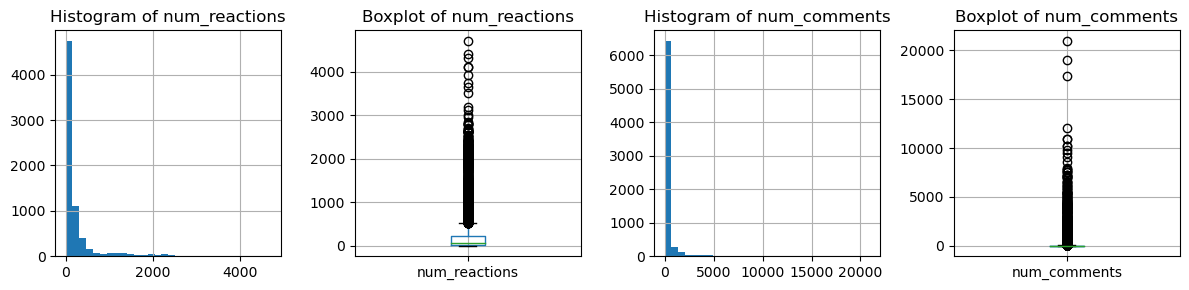

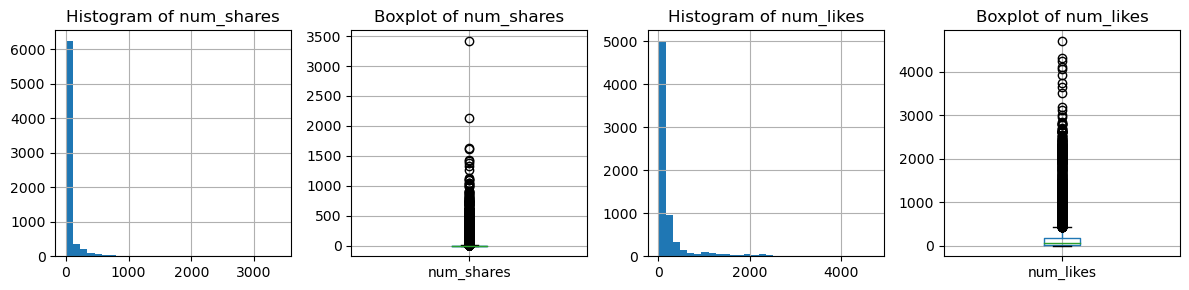

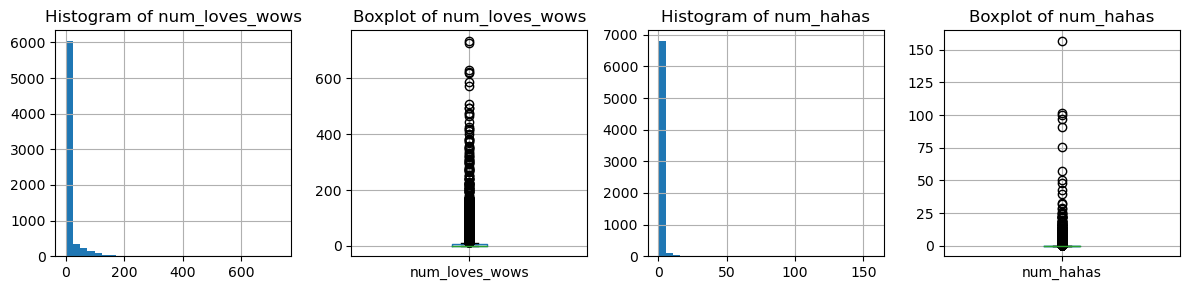

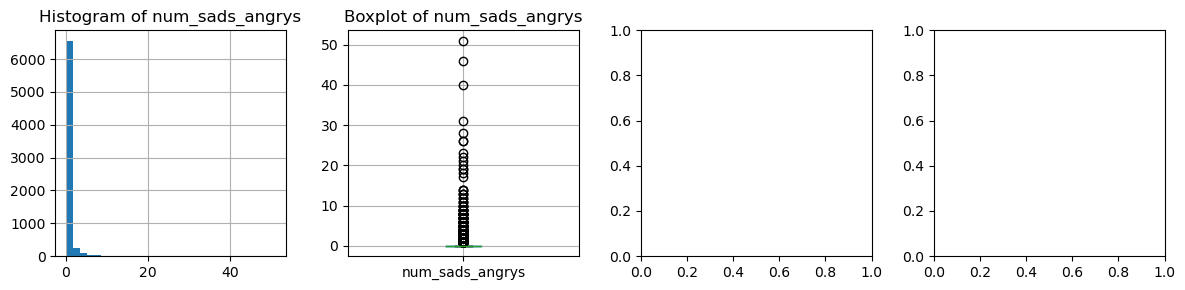

In [25]:
# Iterate over pairs of cols_numericas
for i in range(0, len(cols_numericas), 2):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

    # First pair: Histogram and Boxplot of the first column in the pair
    col1 = cols_numericas[i]
    facebook_tailandia[col1].hist(bins=30, ax=axs[0])
    axs[0].set_title(f'Histogram of {col1}')
    facebook_tailandia.boxplot(column=col1, ax=axs[1])
    axs[1].set_title(f'Boxplot of {col1}')

    # Check if there's a second column in the pair
    if i + 1 < len(cols_numericas):
        col2 = cols_numericas[i + 1]
        facebook_tailandia[col2].hist(bins=30, ax=axs[2])
        axs[2].set_title(f'Histogram of {col2}')
        facebook_tailandia.boxplot(column=col2, ax=axs[3])
        axs[3].set_title(f'Boxplot of {col2}')

    plt.tight_layout()
    plt.show()

Todas y cada una de las variables numéricas "puras" tienen un sesgo hacia la derecha con muchos outliers, resultado de que la mayoría tienen poco "engagement", y solo una pequeña proporción sí tiene reacciones.

En otras palabras, los gráficos de frecuencia (histogramas) para cada una de las variables tiene muchos valores bajos (cero reacciones, una reacción, etc.), y una cola de valores menos frecuentes hacia la derecha. En otras palabras, la gráfica de frecuencias de cada variable está sesgada hacia la derecha ("right skew").

In [26]:
facebook_tailandia[cols_numericas].describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys
count,6996.000000,6996.000000,6996.000000,6996.000000,6996.000000,6996.000000,6996.000000
mean,225.091052,225.648799,40.275872,210.036735,14.010435,0.698256,0.342910
std,452.953875,892.922206,132.072584,439.623067,45.194524,3.971738,1.721095
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000
50%,58.000000,4.000000,0.000000,57.000000,0.000000,0.000000,0.000000
75%,216.000000,22.250000,4.000000,182.000000,5.000000,0.000000,0.000000
max,4710.000000,20990.000000,3424.000000,4710.000000,735.000000,157.000000,51.000000


En todo caso, está claro que a estas les aplicaremos Robust Scaler, cosa que hacemos a continuación.

In [27]:
robust_sc = RobustScaler()

for column in cols_numericas:  # Hemos dicho que a las cols. numéricas les aplicaremos Robust Scalerr.
    facebook_tailandia[column] = robust_sc.fit_transform(facebook_tailandia[[column]])

In [28]:
facebook_tailandia

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys
0,video,4/22/2018 6:00,2.366834,22.831461,65.50,2.272727,19.0,1.0,1.0
1,photo,4/21/2018 22:45,0.462312,-0.179775,0.00,0.563636,0.0,0.0,0.0
2,video,4/21/2018 6:17,0.849246,10.426966,14.25,0.890909,4.4,1.0,0.0
3,photo,4/21/2018 2:29,0.266332,-0.179775,0.00,0.327273,0.0,0.0,0.0
4,photo,4/18/2018 3:22,0.778894,-0.179775,0.00,0.890909,1.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...
7045,photo,9/24/2016 2:58,0.155779,-0.179775,0.00,0.193939,0.0,0.0,0.0
7046,photo,9/23/2016 11:19,-0.211055,-0.179775,0.00,-0.260606,0.2,1.0,0.0
7047,photo,9/21/2016 23:03,-0.281407,-0.179775,0.00,-0.339394,0.2,0.0,0.0
7048,photo,9/20/2016 0:43,1.472362,0.359551,5.50,1.769697,0.4,0.0,0.0


Como anticipábamos antes, las últimas cuatro columnas ni se han inmutado al aplicar Robust Scaler. Si fuera necesario, podríamos aplicar otra transformación, pero por ahora lo dejamos como está.

In [29]:
facebook_tailandia[cols_numericas].describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys
count,6996.000000,6996.000000,6996.000000,6996.000000,6996.000000,6996.000000,6996.000000
mean,0.839654,9.961744,10.068968,0.927495,2.802087,0.698256,0.342910
std,2.276150,40.131335,33.018146,2.664382,9.038905,3.971738,1.721095
min,-0.291457,-0.179775,0.000000,-0.345455,0.000000,0.000000,0.000000
25%,-0.206030,-0.179775,0.000000,-0.242424,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.793970,0.820225,1.000000,0.757576,1.000000,0.000000,0.000000
max,23.376884,943.191011,856.000000,28.200000,147.000000,157.000000,51.000000


C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


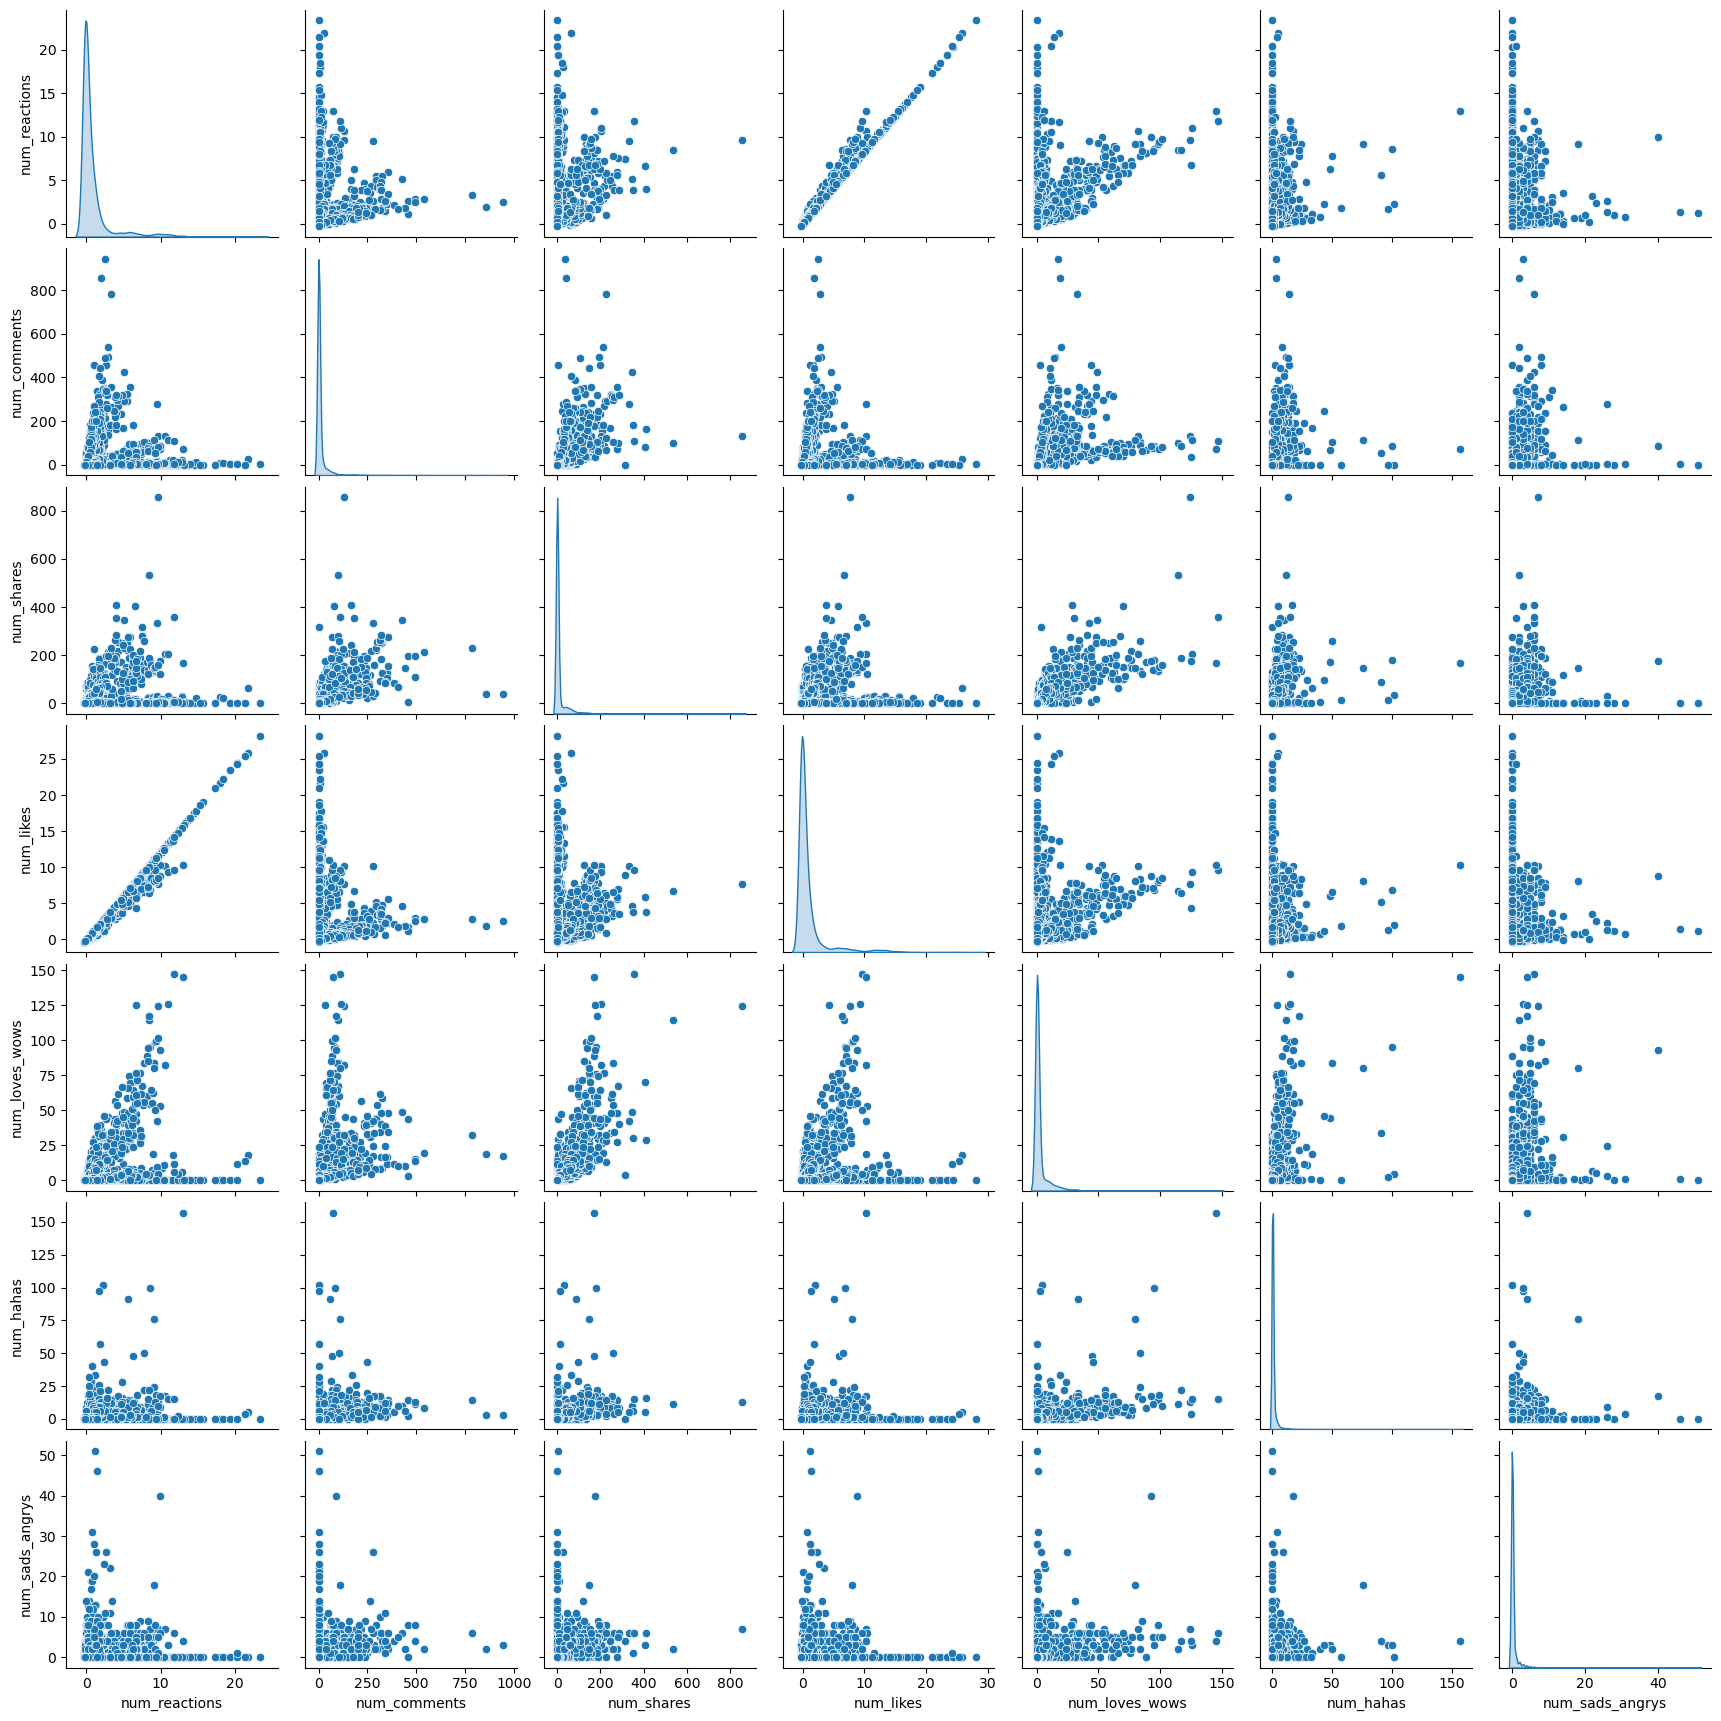

In [30]:
sns.pairplot(facebook_tailandia[cols_numericas], diag_kind='kde')

Del todo lo anterior podemos deducir lo siguiente:

Vemos en general que parece haber correlaciones, más claras o menos claras entre "num_reactions" y el resto de variables numéricas. En todo caso, es muy lógico: en el dataframe se recogen reacciones, de manera que todas ellas correlacionarán, mucho o poco, con la variable "num_reactions".

En particular, lo más llamativo es que hay una correlación lineal positiva meridianamente clara entre "num_reactions" y "num_likes". Una explicación es que es la reacción más sencilla y rápida de efectuar: cuesta prácticamente cero tiempo y esfuerzo.

Aparte de esta correlación tan clara, también se correlaciona "num_reactions" de forma más difusa con el resto de reacciones, siendo "num_comments" y "num_shares" las siguientes en importancia después de "num_likes". Son acciones más elaboradas que un simple like, pero si hay reacción, parecen ser las siguientes reacciones más probables.

A distancia en cuanto a frecuencia, le seguirán las otras reacciones, mucho menos frecuentes. Un "love", un "sad" o un "haha" no han de costar apenas más esfuerzo que un "like", pero probablemente por ser menos frecuentes, se piensa menos en ellas al reaccionar.

### Trabajo con fecha

Para sacar información de la fecha, convertimos el "object" llamado "status_published" a tipo objeto "datetime":

In [31]:
facebook_tailandia['status_published'] = pd.to_datetime(facebook_tailandia['status_published'], errors='coerce')

In [32]:
facebook_tailandia['status_published'].isna().sum()

0

Todo ha ido bien, no se han generado valores "NaN" (que era un riesgo con errors="coerce"). Y ahora además ya tenemos que el tipo de dato es un objeto "datetime".

In [33]:
facebook_tailandia.dtypes

status_type                 object
status_published    datetime64[ns]
num_reactions              float64
num_comments               float64
num_shares                 float64
num_likes                  float64
num_loves_wows             float64
num_hahas                  float64
num_sads_angrys            float64
dtype: object

Una vez hemos hecho esto, de aquí podemos extraer más información: la hora, el día, el mes, etc. (ya sea como códigos numéricos o como nombres).

In [34]:
facebook_tailandia['status_published']

0      2018-04-22 06:00:00
1      2018-04-21 22:45:00
2      2018-04-21 06:17:00
3      2018-04-21 02:29:00
4      2018-04-18 03:22:00
               ...        
7045   2016-09-24 02:58:00
7046   2016-09-23 11:19:00
7047   2016-09-21 23:03:00
7048   2016-09-20 00:43:00
7049   2016-09-10 10:30:00
Name: status_published, Length: 6996, dtype: datetime64[ns]

In [35]:
'''
facebook_tailandia['Day_of_Week'] = facebook_tailandia['status_published'].dt.dayofweek # day_name()  nos lo daría como string.
facebook_tailandia['Month'] = facebook_tailandia['status_published'].dt.month # month_name() nos lo daría como string.
facebook_tailandia['Year'] = facebook_tailandia['status_published'].dt.year
facebook_tailandia['Hour'] = facebook_tailandia['status_published'].dt.hour
facebook_tailandia['Minute'] = facebook_tailandia['status_published'].dt.minute
'''

"\nfacebook_tailandia['Day_of_Week'] = facebook_tailandia['status_published'].dt.dayofweek # day_name()  nos lo daría como string.\nfacebook_tailandia['Month'] = facebook_tailandia['status_published'].dt.month # month_name() nos lo daría como string.\nfacebook_tailandia['Year'] = facebook_tailandia['status_published'].dt.year\nfacebook_tailandia['Hour'] = facebook_tailandia['status_published'].dt.hour\nfacebook_tailandia['Minute'] = facebook_tailandia['status_published'].dt.minute\n"

In [36]:
facebook_tailandia['status_published'].dtype


dtype('<M8[ns]')

Decido utilizar la información del objeto "datetime" para crear diversas variables binarias a continuación.

### Crear variables binarias a partir de otras variables

Podríamos a partir de los meses definir una función para, grosso modo, indicar si el post fue en invierno, verano, primavera u otoño.

In [37]:
def estaciones(month):  # Le damos un mes (en formato "número", del 1 al 12)
    if month in [3, 4, 5]:  # Nota: he preferido ponerlo en texto, para facilitar la interpretación posterior.
        return "primavera"  # Primavera, 2
    elif month in [6, 7, 8]:
        return "verano"  # Verano, 3
    elif month in [9, 10, 11]:
        return "otoño"  # Otoño, 4
    else:
        return "invierno"  # Invierno, 1 (si mes es igual a 0, 1 o 2)

facebook_tailandia['Season'] = facebook_tailandia['status_published'].dt.month.apply(estaciones)

También podríamos a partir de la hora definir "bloques del día": Madrugada (o mañana temprana), mañana, tarde y noche:

In [38]:
def segmento_dia(hour):  # Le damos una hora (en formato "int", desde el 0 al 23)
    if hour in range(0, 7):
        return "madrugada"  # Madrugada, 1
    elif hour in range(7, 13):
        return "mañana"  # Mañana, 2
    elif hour in range(13, 19):
        return "tarde"  # Tarde, 3
    else:
        return "noche"  # Noche, 4

facebook_tailandia['Segmento día'] = facebook_tailandia['status_published'].dt.hour.apply(segmento_dia)  

Otra variable que podríamos considerar, es si influye el que sea "casi la hora en punto" (porque tal vez la gente escriba con prisas), o recién pasó la hora (porque tal vez alguna gente queda libre y consulta sus redes y reacciona)

In [39]:
def segmento_hora(minute):  # ¿Acaban de quedar libres o se les acaba el tiempo antes de la hora en punto?
    if minute in range(0, 8):
        return "recién libre"  # Inicio de hora
    elif minute in range(53, 60):
        return "casi en punto"  # Final de hora
    else:
        return "valle"  # "Tiempo "valle" de la hora que sea
    
facebook_tailandia['Segmento hora'] = facebook_tailandia['status_published'].dt.minute.apply(segmento_hora)

Otra variable podría ser si es fin de semana o no:

In [40]:
def es_finde(datetime):  # Un objeto "datetime", que viene de la columna 'status_published'
    day = datetime.dayofweek   #  Nota mental: añadir .dt. solo es necesario aplicándolo a una serie.
    hour = datetime.hour
    if day in [5, 6]:  # 5 y 6 corresponden a sábado y domingo. 
        return 1  # Es fin de semana
    elif day == 4 and hour >= 18:  # Es viernes por la tarde, así que es finde.
        return 1  # Es fin de semana.
    else:
        return 0  # No es finde.

# Ensure that 'status_published' or similar column containing datetime objects is used
facebook_tailandia['Es finde'] = facebook_tailandia['status_published'].apply(es_finde)

In [126]:
facebook_tailandia

,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys,Es finde,status_type_link,status_type_photo,...,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre,Clusters k-means,Clusters_HC
0,2.366834,22.831461,65.50,2.272727,19.0,1.0,1.0,1,0,0,...,0,1,0,1,0,0,0,1,2,0
1,0.462312,-0.179775,0.00,0.563636,0.0,0.0,0.0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
2,0.849246,10.426966,14.25,0.890909,4.4,1.0,0.0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0.266332,-0.179775,0.00,0.327273,0.0,0.0,0.0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
4,0.778894,-0.179775,0.00,0.890909,1.8,0.0,0.0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,0.155779,-0.179775,0.00,0.193939,0.0,0.0,0.0,1,0,1,...,1,0,0,1,0,0,1,0,0,0
6992,-0.211055,-0.179775,0.00,-0.260606,0.2,1.0,0.0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
6993,-0.281407,-0.179775,0.00,-0.339394,0.2,0.0,0.0,0,0,1,...,1,0,0,0,1,0,0,1,0,0
6994,1.472362,0.359551,5.50,1.769697,0.4,0.0,0.0,0,0,1,...,1,0,0,1,0,0,0,0,0,0


Llegados a este punto, consideramos terminadas las transformaciones a las variables numéricas y a la fecha.

Nota: no he incorporado las fechas y horas como tal, al considerar que podían aportar mucha dimensionalidad y que de algún modo las categóricas que he creado "encapsulan" lo que nos podrían decir esos datos.

A las variables categóricas que he creado antes, les aplicamos "get_dummies" para convertirlas en binarias.

In [42]:
# Convert 'status_type' column into dummy/indicator variables
facebook_tailandia = pd.get_dummies(facebook_tailandia, columns=['status_type', 'Season', 'Segmento día', 'Segmento hora'])   # Creamos binarias con get_dummies.


In [43]:
facebook_tailandia

,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys,Es finde,status_type_link,...,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_mañana,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre,Segmento hora_valle
0,2018-04-22 06:00:00,2.366834,22.831461,65.50,2.272727,19.0,1.0,1.0,1,False,...,False,True,False,True,False,False,False,False,True,False
1,2018-04-21 22:45:00,0.462312,-0.179775,0.00,0.563636,0.0,0.0,0.0,1,False,...,False,True,False,False,False,True,False,False,False,True
2,2018-04-21 06:17:00,0.849246,10.426966,14.25,0.890909,4.4,1.0,0.0,1,False,...,False,True,False,True,False,False,False,False,False,True
3,2018-04-21 02:29:00,0.266332,-0.179775,0.00,0.327273,0.0,0.0,0.0,1,False,...,False,True,False,True,False,False,False,False,False,True
4,2018-04-18 03:22:00,0.778894,-0.179775,0.00,0.890909,1.8,0.0,0.0,0,False,...,False,True,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045,2016-09-24 02:58:00,0.155779,-0.179775,0.00,0.193939,0.0,0.0,0.0,1,False,...,True,False,False,True,False,False,False,True,False,False
7046,2016-09-23 11:19:00,-0.211055,-0.179775,0.00,-0.260606,0.2,1.0,0.0,0,False,...,True,False,False,False,True,False,False,False,False,True
7047,2016-09-21 23:03:00,-0.281407,-0.179775,0.00,-0.339394,0.2,0.0,0.0,0,False,...,True,False,False,False,False,True,False,False,True,False
7048,2016-09-20 00:43:00,1.472362,0.359551,5.50,1.769697,0.4,0.0,0.0,0,False,...,True,False,False,True,False,False,False,False,False,True


Eliminamos "status_published", ya que no la utilizaremos más "per se":

In [44]:
facebook_tailandia = facebook_tailandia.drop(["status_published"], axis = 1)

Vemos que de la creación de binarias nos han salido valores booleanos y no binarios numéricos. Los transformamos a ceros y unos:

In [45]:
for column in facebook_tailandia.columns:
    # Check if the column's data type is bool
    if facebook_tailandia[column].dtype == 'bool':
        # Convert the boolean column to integers
        facebook_tailandia[column] = facebook_tailandia[column].astype(int)
        print("Transformada la columna:", column)
    else:  # Si no es una de las variables que quedaron como booleanas.
        print("Circulen, no hay nada que ver...")

Circulen, no hay nada que ver...
Circulen, no hay nada que ver...
Circulen, no hay nada que ver...
Circulen, no hay nada que ver...
Circulen, no hay nada que ver...
Circulen, no hay nada que ver...
Circulen, no hay nada que ver...
Circulen, no hay nada que ver...
Transformada la columna: status_type_link
Transformada la columna: status_type_photo
Transformada la columna: status_type_status
Transformada la columna: status_type_video
Transformada la columna: Season_invierno
Transformada la columna: Season_otoño
Transformada la columna: Season_primavera
Transformada la columna: Season_verano
Transformada la columna: Segmento día_madrugada
Transformada la columna: Segmento día_mañana
Transformada la columna: Segmento día_noche
Transformada la columna: Segmento día_tarde
Transformada la columna: Segmento hora_casi en punto
Transformada la columna: Segmento hora_recién libre
Transformada la columna: Segmento hora_valle


In [46]:
facebook_tailandia

,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys,Es finde,status_type_link,status_type_photo,...,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_mañana,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre,Segmento hora_valle
0,2.366834,22.831461,65.50,2.272727,19.0,1.0,1.0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
1,0.462312,-0.179775,0.00,0.563636,0.0,0.0,0.0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
2,0.849246,10.426966,14.25,0.890909,4.4,1.0,0.0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
3,0.266332,-0.179775,0.00,0.327273,0.0,0.0,0.0,1,0,1,...,0,1,0,1,0,0,0,0,0,1
4,0.778894,-0.179775,0.00,0.890909,1.8,0.0,0.0,0,0,1,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045,0.155779,-0.179775,0.00,0.193939,0.0,0.0,0.0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
7046,-0.211055,-0.179775,0.00,-0.260606,0.2,1.0,0.0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
7047,-0.281407,-0.179775,0.00,-0.339394,0.2,0.0,0.0,0,0,1,...,1,0,0,0,0,1,0,0,1,0
7048,1.472362,0.359551,5.50,1.769697,0.4,0.0,0.0,0,0,1,...,1,0,0,1,0,0,0,0,0,1


Para evitar multicolinearidad, de cada subconjunto de variables binarias interrelacionadas, deberíamos eliminar una, idealmente una que pueda considerarse como "línea de base", si es que hay alguna que claramente pueda considerarse así, y si no, una arbitraria.

Así pues, en lo que respecta a "status_type" decido borrar esta: "status_type_status"

En lo que respecta a "Season": "Season_invierno"

En lo que respecta a "Segmento día": "Segmento día_mañana"

Y finalmente, en lo que respecta a "Segmento hora": "Segmento hora_valle"

In [47]:
# Reseteamos el índice para que los registros que quedan sigan siendo perfectamente secuenciales:
facebook_tailandia = facebook_tailandia.reset_index(drop=True)

In [48]:
# Hago un backup para recuperar máas adelante columnas que ahora eliminaré
facebook_tailandia_backup = facebook_tailandia

In [49]:
# Elimino columnas para evitar multicolinearidad
facebook_tailandia = facebook_tailandia.drop(['status_type_status', 'Season_invierno',
                                              'Segmento día_mañana', 'Segmento hora_valle'], axis =1)

En este punto, consideramos terminadas las transformaciones iniciales al conjunto de datos.

### Reducción de dimensionalidad mediante PCA

Exploremos ahora a qué componentes nos interesa aplicar PCA para reducir la dimensionalidad. Este análisis lo aplicaremos a los componentes numéricos, que son todas las columnas que nos quedan hasta la columna "num_angrys". Las que le siguen ya son categóricas.

In [50]:
facebook_tailandia.tail()

,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys,Es finde,status_type_link,status_type_photo,status_type_video,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre
6991,0.155779,-0.179775,0.0,0.193939,0.0,0.0,0.0,1,0,1,0,1,0,0,1,0,0,1,0
6992,-0.211055,-0.179775,0.0,-0.260606,0.2,1.0,0.0,0,0,1,0,1,0,0,0,0,0,0,0
6993,-0.281407,-0.179775,0.0,-0.339394,0.2,0.0,0.0,0,0,1,0,1,0,0,0,1,0,0,1
6994,1.472362,0.359551,5.5,1.769697,0.4,0.0,0.0,0,0,1,0,1,0,0,1,0,0,0,0
6995,-0.206030,-0.179775,0.0,-0.242424,0.0,0.0,0.0,1,0,1,0,1,0,0,0,0,0,0,0


In [51]:
facebook_tailandia.iloc[:,:7]  # Numéricas, a las que aplicaremos el PCA.

,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys
0,2.366834,22.831461,65.50,2.272727,19.0,1.0,1.0
1,0.462312,-0.179775,0.00,0.563636,0.0,0.0,0.0
2,0.849246,10.426966,14.25,0.890909,4.4,1.0,0.0
3,0.266332,-0.179775,0.00,0.327273,0.0,0.0,0.0
4,0.778894,-0.179775,0.00,0.890909,1.8,0.0,0.0
...,...,...,...,...,...,...,...
6991,0.155779,-0.179775,0.00,0.193939,0.0,0.0,0.0
6992,-0.211055,-0.179775,0.00,-0.260606,0.2,1.0,0.0
6993,-0.281407,-0.179775,0.00,-0.339394,0.2,0.0,0.0
6994,1.472362,0.359551,5.50,1.769697,0.4,0.0,0.0


Analizamos la varianza acumulada en función del número de componentes en la PCA para determinar cuántos componentes principales queremos buscar:

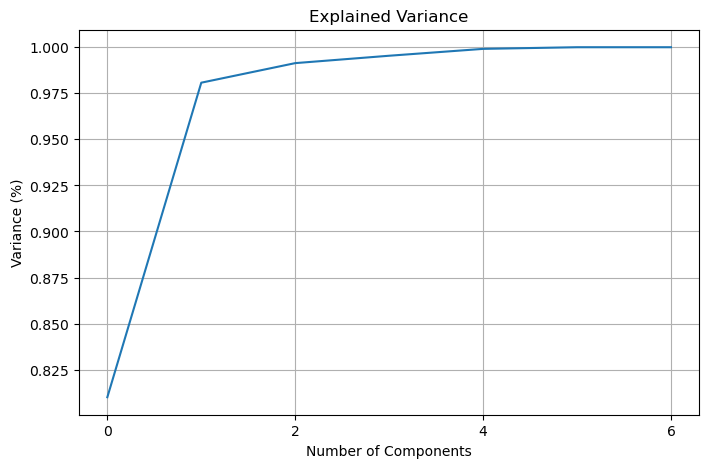

In [52]:
# Fit PCA on the data
pca = PCA().fit(facebook_tailandia.iloc[:,:7])


# Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Explained Variance')
plt.grid(True)

# Set x-axis major ticks to multiple of 2
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(MultipleLocator(2))

plt.show()

Vemos de la representación anterior que con un solo componente ya se explicaría aproximadamente un 98 % de la varianza. Pero como me parece un escándalo reducirlo a un solo componente, decido quedarme con al menos dos, que explicarían aproximadamente el 99 % de la varianza.

Explained Variance:  [0.81005286 0.17069677]


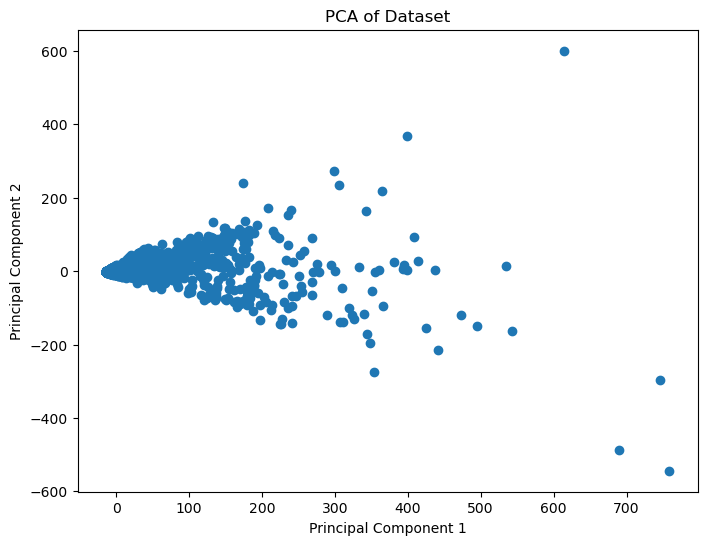

In [53]:
# Applying PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
facebook_tailandia_num_PCA = pca.fit_transform(facebook_tailandia.iloc[:,:7])  # Solo con las numéricas.
principal_df = pd.DataFrame(data=facebook_tailandia_num_PCA, columns=['PC1', 'PC2'])

# Explained Variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance: ", explained_variance)

# Plotting the PCA result
plt.figure(figsize=(8,6))
plt.scatter(principal_df['PC1'], principal_df['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.show()

In [54]:
type(facebook_tailandia_num_PCA)  # Hemos de volver a convertirlo en un dataframe, ahora es un array de NumPy:

numpy.ndarray

In [55]:
facebook_tailandia_num_PCA_df = pd.DataFrame(data=facebook_tailandia_num_PCA, columns=['PC1', 'PC2'])
facebook_tailandia_num_PCA_df

,PC1,PC2
0,45.298546,37.929205
1,-14.422702,-2.129506
2,3.066922,3.243538
3,-14.426757,-2.135905
4,-14.182255,-1.773923
...,...,...
6991,-14.429045,-2.139515
6992,-14.377715,-2.086773
6993,-14.412102,-2.115429
6994,-10.653748,1.878789


Concatenamos los componentes principales con las variables binarias que habíamos generado anteriormente (recordemos, habiendo eliminado algunas para evitar multicolinearidad).

In [56]:
facebook_tailandia_final = pd.concat([facebook_tailandia_num_PCA_df, facebook_tailandia.iloc[:,7:].reset_index(drop=True)], axis=1)

In [57]:
facebook_tailandia_final.iloc[:, :]

,PC1,PC2,Es finde,status_type_link,status_type_photo,status_type_video,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre
0,45.298546,37.929205,1,0,0,1,0,1,0,1,0,0,0,1
1,-14.422702,-2.129506,1,0,1,0,0,1,0,0,1,0,0,0
2,3.066922,3.243538,1,0,0,1,0,1,0,1,0,0,0,0
3,-14.426757,-2.135905,1,0,1,0,0,1,0,1,0,0,0,0
4,-14.182255,-1.773923,0,0,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,-14.429045,-2.139515,1,0,1,0,1,0,0,1,0,0,1,0
6992,-14.377715,-2.086773,0,0,1,0,1,0,0,0,0,0,0,0
6993,-14.412102,-2.115429,0,0,1,0,1,0,0,0,1,0,0,1
6994,-10.653748,1.878789,0,0,1,0,1,0,0,1,0,0,0,0


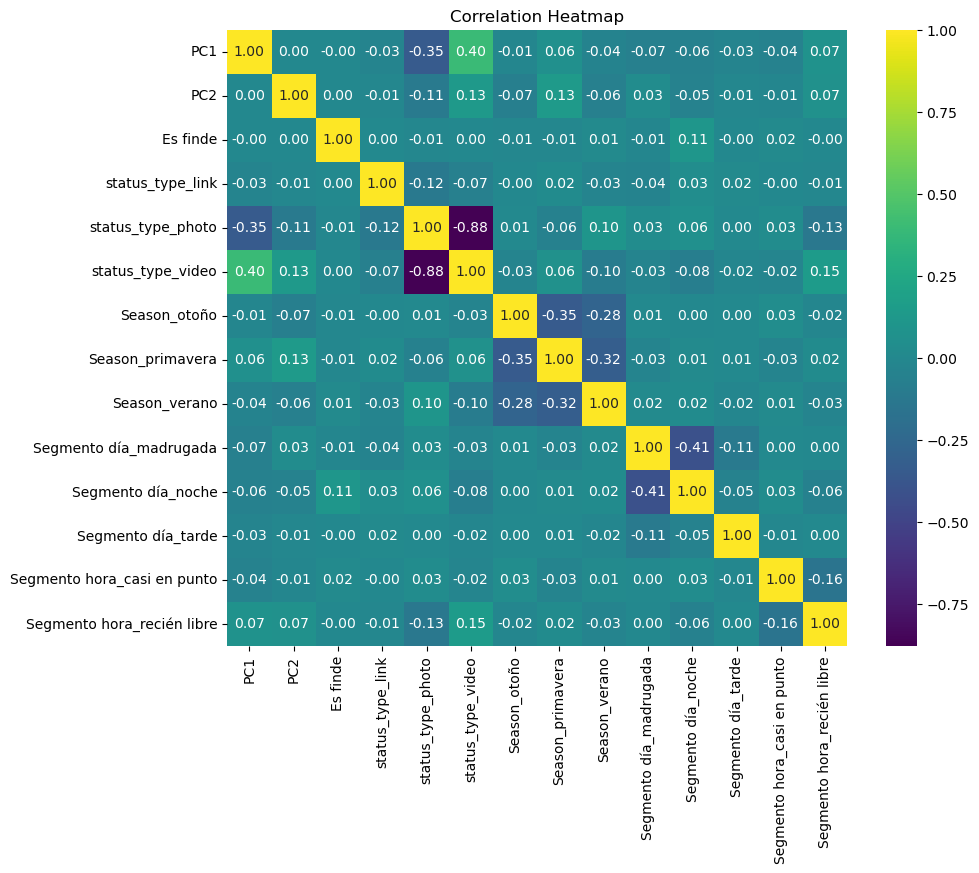

In [58]:

# Calculate the correlation matrix OLD
corr_matrix = facebook_tailandia_final.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.title("Correlation Heatmap")
plt.show()


El "heatmap" nos muesta unas pocas corrrelaciones my fuertes, a saber:

-Hay una correlación muy fuerte entre el componente PC1 y "num_comments", y lo mismo pasa con "num_shares" y "num_loves_wows". Asimismo, una correlación más moderada (valor de casi 0,5) con "num_hahas". Además, hay una leve correlación con las otras reacciones minoritarias "num_hahas" y "num_sads_angrys".

-Más secundariamente, hay una correlación moderada entre el componente PC2 y "num_shares", "num_loves_wows", y una correlación negativa (moderada) con "num_comments".

Una interpretación de qué son el PC1 y el PC2 es la siguiente:

PC1 podría referise a posts en facebook que conseguían involucrar más a la persona lectora, a tal punto que por el motivo que sea, generaban más comentarios y discusión, y que eso a su vez terminaba yendo aparejado a otras reacciones. Más conversación lleva a más conversación. Recordemos además que el componente principal más importante, con diferencia, era PC1, que explicaba más del 95% de la varianza. El componente PC1 podría referirse a contenido muy "engaging", en el que la gente siende más la necesidad de interactuar.

En cambio, el PC2 podría referirse a contenido que, también, era lo bastante interesante como para compartirlo (correlación con "num_shares"), pero no tanto como para lanzarse a discutir/comentar (correlación negativa de PC2 con "num_comments"). Por ese motivo, aunque se compartiesen, no eran posts tan proclives a seguir generando otras reacciones, y por lo tanto influyen menos a la varianza total del conjunto de datos. El componente PC2 podría referirs a contenido simplemente "interesante" o "curioso", pero menos proclive a dar ganas de interacción.

En este punto, podemos proceder a aplicar los algoritmos que nos solicita el ejercicio: k-means, y un clustering jerárquico.

### k-means:

Para aplicar k-means, primero utilizamos el método del codo para determinar el número de clusters óptimo.

C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init

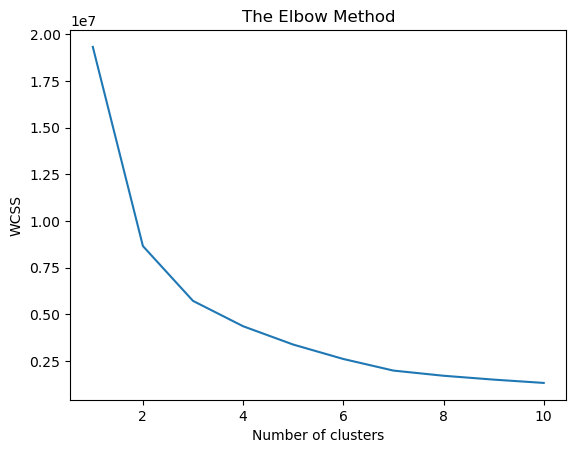

In [59]:
# Calculate WCSS for a range of number of clusters
wcss = []
for i in range(1, 11):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(facebook_tailandia_final)
    wcss.append(kmeans.inertia_)

# Plot the results to observe the 'elbow'
plt.plot(range(1, 11), wcss)  # Adjust the range as needed
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Según el método del codo, deberíamos en k-means utilizar dos, o tres como el número de clusters.

In [60]:
# Apply K-means to the combined data
kmeans = KMeans(n_clusters=3, random_state=0)
clusters_kmeans = kmeans.fit_predict(facebook_tailandia_final)

# Add cluster information back to the original dataframe
facebook_tailandia['Clusters k-means'] = clusters_kmeans

C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


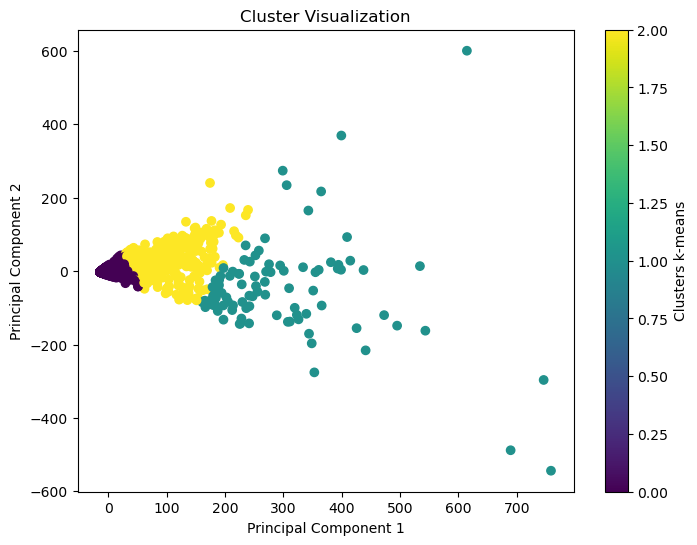

In [61]:
# 2D Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(facebook_tailandia_final['PC1'], facebook_tailandia_final['PC2'], c=facebook_tailandia['Clusters k-means'], cmap='viridis', marker='o')
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Clusters k-means')
plt.show()

Observamos como se han generado tres clusters, siendo el primero uno (en negro) en el cual tenemos valores bajos de ambos componentes principales, otro cluster (en amarillo) con valores intermedios y un último cluster (verde) que incorpora los valores más extremos y dispersos de los componentes principales.

In [62]:
silhouette_avg_kmeans = silhouette_score(facebook_tailandia_final, clusters_kmeans)
print("The average silhouette_score is :", silhouette_avg_kmeans)

The average silhouette_score is : 0.8649071718423552


En principio hemos obtenido un valor de "silhouette score" que es muy bueno, ya que está muy cerca de uno.

### Dendrograma

Para completar lo último que nos pide el ejercicio, aplicamos ahora un algoritmo jerárquico, un clustering mediante un dendrograma:

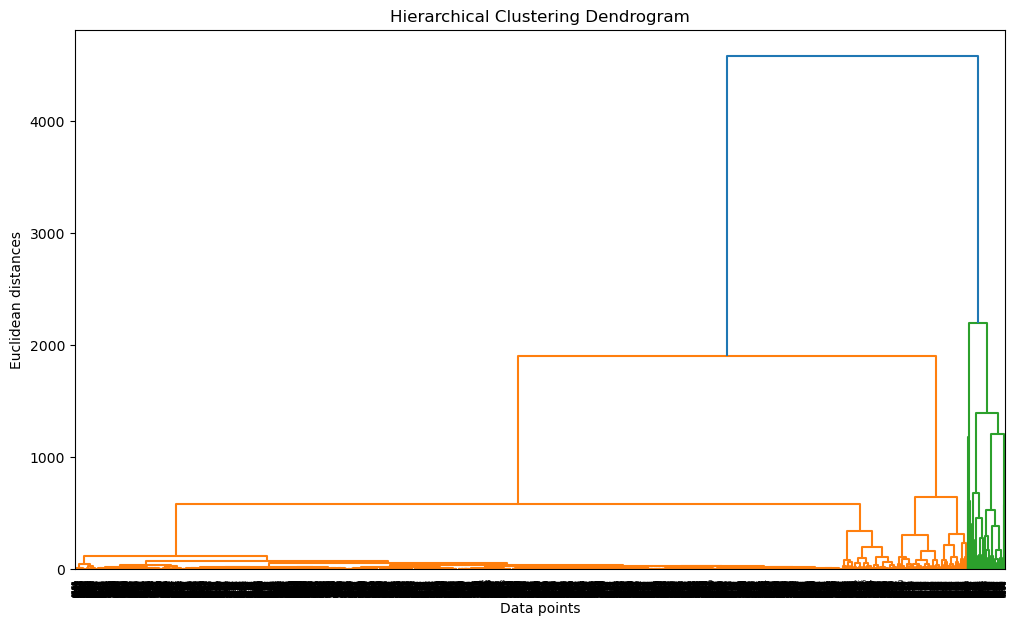

In [63]:
# Generate the linkage matrix
Z = sch.linkage(facebook_tailandia_final, method='ward')  # 'ward' is one of the methods you can use

# Plot the dendrogram to visualize the clustering
plt.figure(figsize=(12, 7))
dendrogram = sch.dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Euclidean distances')
plt.show()

In [64]:
# Hacemos el clustering
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters_hc = hc.fit_predict(facebook_tailandia_final)

# Añadimos los clusters al dataframe original
facebook_tailandia['Clusters_HC'] = clusters_hc

C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


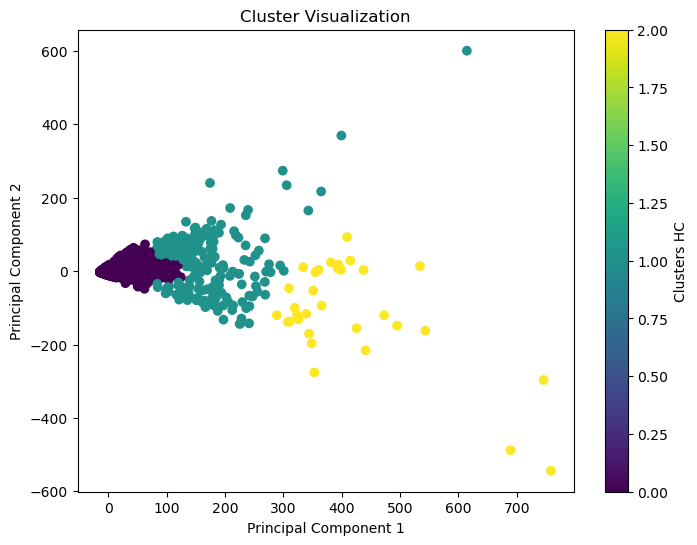

In [65]:
# 2D Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(facebook_tailandia_final['PC1'], facebook_tailandia_final['PC2'], c=facebook_tailandia['Clusters_HC'], cmap='viridis', marker='o')
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Clusters HC')
plt.show()

Al menos visualmente, el resultado es algo parecido al anterior con k-means.

In [66]:
silhouette_avg_hc = silhouette_score(facebook_tailandia_final, clusters_hc)
print("The average silhouette_score is :", silhouette_avg_hc)

The average silhouette_score is : 0.890741954786847


Nuevamente, obtenemos un buen "silhouette score", muy cercano a uno (incluso más cercano que antes).

In [67]:
# "Cophenetic distances"... ¿?¿?¿?¿?
c, coph_dists = sch.cophenet(Z, pdist(facebook_tailandia_final))
print("Cophenetic Correlation Coefficient:", c)

Cophenetic Correlation Coefficient: 0.8399159418555722


Si comparamos los resultados entre los dos modelos de clustering obtenidos, vemos que el "silhouette score" es levemente mayor (pero muy parecido en el caso de k-means). Si, solo en base a este dato debiéramos decidirnos por uno u otro modelo, podríamos decidirnos por k-means.

### Análisis final y conclusiones

Una vez llegados a este punto, veamos qué nos permiten decir los datos sobre los clusters obtenidos. Pero para eso, generemos un último dataframe que incorpore las variables que habíamos evitado para evitar multicolinearidad, con objeto de facilitar la interpretación.

In [68]:
facebook_tailandia_backup.head()  # Habíamos guardado una versión "intacta" del dataframe sin los descartes.

,num_reactions,num_comments,num_shares,num_likes,num_loves_wows,num_hahas,num_sads_angrys,Es finde,status_type_link,status_type_photo,...,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_mañana,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre,Segmento hora_valle
0,2.366834,22.831461,65.50,2.272727,19.0,1.0,1.0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
1,0.462312,-0.179775,0.00,0.563636,0.0,0.0,0.0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
2,0.849246,10.426966,14.25,0.890909,4.4,1.0,0.0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
3,0.266332,-0.179775,0.00,0.327273,0.0,0.0,0.0,1,0,1,...,0,1,0,1,0,0,0,0,0,1
4,0.778894,-0.179775,0.00,0.890909,1.8,0.0,0.0,0,0,1,...,0,1,0,1,0,0,0,0,0,1


In [69]:
facebook_tailandia_analisis = pd.concat([facebook_tailandia_final.iloc[:, :2], facebook_tailandia_backup.iloc[:, 7:]], axis=1)
facebook_tailandia_analisis

,PC1,PC2,Es finde,status_type_link,status_type_photo,status_type_status,status_type_video,Season_invierno,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_mañana,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre,Segmento hora_valle
0,45.298546,37.929205,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0
1,-14.422702,-2.129506,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2,3.066922,3.243538,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1
3,-14.426757,-2.135905,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
4,-14.182255,-1.773923,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,-14.429045,-2.139515,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
6992,-14.377715,-2.086773,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
6993,-14.412102,-2.115429,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
6994,-10.653748,1.878789,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1


El dataframe anterior incorpora por un lado los componentes principales PC1 (habíamos sugerido que relacionado con contenido "engaging"), PC2 (habíamos sugerido que relacionado con contenido solamente "interesante"), y todas las variable binarias, y también las columnas . Ahora, añadamos la información correspondiente a qué cluster pertenece cada registro.

Incorporamos como dos nuevas columnas la clasificación por k-means y la clasificación mediante clustering jerárquico:

In [70]:
# Incorporarlos, pero en la matriz de correlación, omitirlos.
facebook_tailandia_analisis['Clusters k-means'] = facebook_tailandia['Clusters k-means']
facebook_tailandia_analisis['Clusters_HC'] = facebook_tailandia['Clusters_HC']

In [71]:
facebook_tailandia_analisis

,PC1,PC2,Es finde,status_type_link,status_type_photo,status_type_status,status_type_video,Season_invierno,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_mañana,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre,Segmento hora_valle,Clusters k-means,Clusters_HC
0,45.298546,37.929205,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,2,0
1,-14.422702,-2.129506,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,3.066922,3.243538,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
3,-14.426757,-2.135905,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
4,-14.182255,-1.773923,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,-14.429045,-2.139515,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
6992,-14.377715,-2.086773,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
6993,-14.412102,-2.115429,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
6994,-10.653748,1.878789,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0


Nota: en k-means y HC el cluster 1 y el 2 están intercambiados (ver gráficos más arriba). Eso significa que el cluster 1 de k-means se parece al cluster 2 de HC, y que el cluster 2 de k-means se parece el cluster 1 de HC.

Para que la comparación entre clusters sea más directa, apliquemos una función lambda para que el número de cluster de k-means y HC sea el mismo entre los clusters más parecidos (básicamnente, intercambiamos los valores 1 y 2 en la columna "Clusters_HC").

In [92]:
len(facebook_tailandia_analisis[facebook_tailandia_analisis['Clusters_HC'] == 2])

33

In [93]:
facebook_tailandia_analisis['Clusters_HC'] = facebook_tailandia_analisis['Clusters_HC'].apply(lambda x: 2 if x == 1 else 1 if x == 2 else x)

In [94]:
len(facebook_tailandia_analisis[facebook_tailandia_analisis['Clusters_HC'] == 2])

247

Bien, hecho el ajuste anterior, echemos primero una mirada numérica a todo esto.

Veamos qué características tiene cada cluster de k-means. Lo primero que vemos al hacer una inspección visual de cada cluster (centrándonos en k-means) es que hay más acuerdo entre k-means y el algoritmo de clasificación jerárquica en el cluster cero, algo menos en el uno, y más discrepancias de clasificación en el dos.

In [72]:
facebook_tailandia_analisis[facebook_tailandia_analisis['Clusters k-means'] == 0]#.head()

,PC1,PC2,Es finde,status_type_link,status_type_photo,status_type_status,status_type_video,Season_invierno,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_mañana,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre,Segmento hora_valle,Clusters k-means,Clusters_HC
1,-14.422702,-2.129506,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,3.066922,3.243538,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
3,-14.426757,-2.135905,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
4,-14.182255,-1.773923,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
5,-14.046030,-2.052639,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,-14.429045,-2.139515,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
6992,-14.377715,-2.086773,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
6993,-14.412102,-2.115429,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
6994,-10.653748,1.878789,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0


Veamos qué podemos decir sobre el tamaño de los clusters.

In [99]:
num_clusters = [0, 1, 2]
clusterings = ('Clusters k-means', 'Clusters_HC') 

In [100]:
for i in num_clusters:
        print("Tamaño cluster:", i, "k-means:")
        print(len(facebook_tailandia_analisis[
            (facebook_tailandia_analisis['Clusters k-means'] == i)
        ]))

        print("Tamaño cluster:", i, "HC:")
        print(len(facebook_tailandia_analisis[
            (facebook_tailandia_analisis['Clusters_HC'] == i)
        ]))
        print()

Tamaño cluster: 0 k-means:
6379
Tamaño cluster: 0 HC:
6716

Tamaño cluster: 1 k-means:
102
Tamaño cluster: 1 HC:
33

Tamaño cluster: 2 k-means:
515
Tamaño cluster: 2 HC:
247



En ambos casos, el más grande con diferencia es el cluster cero.

Hay una discrepancia entre el número de elementos en cada cluster, pero el más grande, el segundo, y el tercero en tamaño es el mismo en cada caso.

In [101]:
for i in num_clusters:
    for j in range(0, 3):
        print("k-means cluster:", i, " HC cluster:", j)
        print("Número de registros que se solapan:", len(facebook_tailandia_analisis[
            (facebook_tailandia_analisis['Clusters k-means'] == i) & 
            (facebook_tailandia_analisis['Clusters_HC'] == j)
        ]))
        print()

k-means cluster: 0  HC cluster: 0
Número de registros que se solapan: 6379

k-means cluster: 0  HC cluster: 1
Número de registros que se solapan: 0

k-means cluster: 0  HC cluster: 2
Número de registros que se solapan: 0

k-means cluster: 1  HC cluster: 0
Número de registros que se solapan: 0

k-means cluster: 1  HC cluster: 1
Número de registros que se solapan: 33

k-means cluster: 1  HC cluster: 2
Número de registros que se solapan: 69

k-means cluster: 2  HC cluster: 0
Número de registros que se solapan: 337

k-means cluster: 2  HC cluster: 1
Número de registros que se solapan: 0

k-means cluster: 2  HC cluster: 2
Número de registros que se solapan: 178



Un punto de acuerdo entre los dos métodos es que todo lo que k-means ha clasificado como "cluster cero", el dendrograma también. Más allá, surgen diferencias en la clasificación.

Existen algunos elementos que k-means ha clasificado como "cluster 1" pero que HC clasifica como "cluster 2".

También pasa que algunos elementos que k-means ha clasificado como "cluster 2", HC los clasifica como "cluster 0".

In [113]:
facebook_tailandia_analisis.head()

,PC1,PC2,Es finde,status_type_link,status_type_photo,status_type_status,status_type_video,Season_invierno,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_mañana,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre,Segmento hora_valle,Clusters k-means,Clusters_HC
0,45.298546,37.929205,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,2,0
1,-14.422702,-2.129506,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,3.066922,3.243538,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
3,-14.426757,-2.135905,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
4,-14.182255,-1.773923,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0


Veamos qué características podemos deducir comparando los clusters en función de sus "rasgos promedio". Obtendremos el valor promedio de cada variable, y veremos qué nos dice esto:

In [121]:
averages_dict = {}  # Diccionario para almacenar la información que generaremos

# Columnas de interés
columns_to_include = facebook_tailandia_analisis.columns.difference(clusterings)  # No procesaremos las columnas Clusters k-means y Clusters_HC

# Medias de cada variable para cada clúster de K-means
for i in num_clusters:
    cluster_key = f'clu{i}_kmeans'
    filtered_df = facebook_tailandia_analisis[facebook_tailandia_analisis['Clusters k-means'] == i]
    averages_dict[cluster_key] = filtered_df[columns_to_include].mean()

# Medias de cada variable para cada clúster jerárquico
for i in num_clusters:
    cluster_key = f'clu{i}_hc'
    filtered_df = facebook_tailandia_analisis[facebook_tailandia_analisis['Clusters_HC'] == i]
    averages_dict[cluster_key] = filtered_df[columns_to_include].mean()

# Conversión del diccionario a dataframe
averages_df = pd.DataFrame(averages_dict).T

averages_df

,Es finde,PC1,PC2,Season_invierno,Season_otoño,Season_primavera,Season_verano,Segmento día_madrugada,Segmento día_mañana,Segmento día_noche,Segmento día_tarde,Segmento hora_casi en punto,Segmento hora_recién libre,Segmento hora_valle,status_type_link,status_type_photo,status_type_status,status_type_video
clu0_kmeans,0.313215,-11.350137,-1.487974,0.271359,0.240947,0.275592,0.212102,0.487224,0.336260,0.163035,0.013482,0.110049,0.153472,0.736479,0.009876,0.664524,0.056278,0.269321
clu1_kmeans,0.352941,289.333758,-48.576628,0.186275,0.254902,0.323529,0.235294,0.186275,0.725490,0.088235,0.000000,0.029412,0.147059,0.823529,0.000000,0.009804,0.000000,0.990196
clu2_kmeans,0.314563,83.282483,28.051657,0.332039,0.159223,0.382524,0.126214,0.456311,0.469903,0.071845,0.001942,0.067961,0.365049,0.566990,0.000000,0.003883,0.000000,0.996117
clu0_hc,0.314026,-7.901456,-0.413102,0.279333,0.235408,0.278291,0.206968,0.487046,0.340083,0.159917,0.012954,0.108100,0.167659,0.724241,0.009381,0.631328,0.053454,0.305837
clu1_hc,0.272727,414.025034,-109.517010,0.181818,0.424242,0.272727,0.121212,0.151515,0.787879,0.060606,0.000000,0.000000,0.212121,0.787879,0.000000,0.030303,0.000000,0.969697
clu2_hc,0.315789,159.527734,25.864201,0.157895,0.202429,0.445344,0.194332,0.348178,0.611336,0.040486,0.000000,0.056680,0.198381,0.744939,0.000000,0.004049,0.000000,0.995951


De lo anterior, parece que podemos decir que, en promedio, el cluster cero tanto de kmeans como clustering jerárquico muestra valores moderados y negativos de los componentes principales. Es decir, valores no muy altos de PC1 (contenido particularmente "engaging"), ni del componente PC2 (contenido simplemtente "algo interesante").

Sobre el cluster cero podemos decir también que está repartido de forma parecida a lo largo de las estaciones del año, y que la mayoría de posts son de madrugada (00:00-06:00) o por la mañana (06:00-13:00). La mayoría de estos contenidos son fotos, seguido de videos.


Después, el cluster uno tiene valores muy altos de PC1 (posible contenido particularmente "engaging"), y muy bajos de PC2 (que es contenido menos engaging). Podemos decir que hay un cierto enriquecimiento de posts en este cluster en primavera (según k-means), y hay menos posts de cluster uno en invierno (según ambos algoritmos). Casi el ochenta porciento de estos posts se crearon por la mañana (06:00-13:00). La inmensa mayoría contienen videos (96-99%).


Finalmente, el cluster dos tiene valores bastante altos de PC1 (contenido engaging), pero también de PC2 (contenido solamente interesante). Según ambos algoritmos está enriquecido con posts hechos en primavera. Son posts hechos de madrugada o por la mañana y muy altos en contenido de videos (99%). 

En conclusión, si hubiéramos de resumir lo que vemos de ello, podríamos decir que hay tres grupos diferenciados de posts en la muestra de datos sobre facebook en Tailandia:
    
a) El más mayoritario, que contiene aquellos que consiguen algunas reacciones, pero no muchísimas, y que contienen fotos.

b) Aquellos que contienen videos, son posts creados por la mañana, y son muy "engaging".

c) Aquellos que consiguen mucho engagement, pero también reacciones menos interactivas, siendo posts hechos por la madrugada o por la mañana, y también muy altos en cuanto a contenido de video.